In [1]:
# 준비
import pandas as pd
import numpy as np
import warnings
import os
import sys

import scipy.stats as spst

ipynb_path = 'C:/Users/User/Documents/Wind_Power/notebooks'
src_path = 'C:/Users/User/Documents/Wind_Power/src'
input_path = "C:/Users/User/Documents/Wind_Power/input/"

In [2]:
sys.path.append(src_path)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask
import dask.dataframe as dd
from windpowerlib.wind_speed import logarithmic_profile
from utils import uv_to_wsd


In [3]:
power = pd.read_parquet(input_path + "dynamic_report_ewp02_2020_10min.parquet").rename({'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}, axis=1)
gj_y = pd.read_parquet(input_path + "train_y.parquet").rename({'end_datetime': 'dt'}, axis=1)
ldaps = pd.read_parquet(input_path + "train_ldaps_gyeongju.parquet")

print("Power: ", power.shape)
print("train_y: ", gj_y.shape)
print("LDAPS: ", ldaps.shape)

Power:  (52592, 29)
train_y:  (52608, 4)
LDAPS:  (235818, 15)


In [4]:
# data slicing
power = power[:-3]

datas = [power, gj_y, ldaps]
for d in datas:
    try:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_convert("Asia/Seoul"))
    except TypeError:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_localize("Asia/Seoul"))

gj_y = (gj_y.loc[(gj_y['plant_name'] == "경주풍력")
                 & (gj_y['dt']).between('2020-01-01', '2021-01-01', inclusive='left')])

ldaps = ldaps.loc[ldaps['dt'].between('2020-01-01', '2021-01-01', inclusive='left')]

print("Power: ", power.shape, power['dt'].min(), power['dt'].max())
print("train_y: ", gj_y.shape, gj_y['dt'].min(), gj_y['dt'].max())
print("LDAPS: ", ldaps.shape, ldaps['dt'].min(), ldaps['dt'].max())

Power:  (52589, 29) 2020-01-01 00:00:00+09:00 2020-12-31 23:50:00+09:00
train_y:  (8783, 4) 2020-01-01 01:00:00+09:00 2020-12-31 23:00:00+09:00
LDAPS:  (78840, 15) 2020-01-02 00:00:00+09:00 2020-12-31 23:00:00+09:00


In [5]:
ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
    ldaps["wind_u_10m"], ldaps["wind_v_10m"]
)

ldaps["wind_speed_100m"] = logarithmic_profile(ldaps["wind_speed"], 10, 100, 0.3)

C:\Users\User\AppData\Local\Temp\ipykernel_13212\4022820924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
C:\Users\User\AppData\Local\Temp\ipykernel_13212\4022820924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
C:\Users\User\AppData\Local\Temp\ipykernel_13212\4022820924.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [6]:
power['turbine_id'].value_counts()

turbine_id
WTG01    52589
Name: count, dtype: int64

In [7]:
gj_y.tail()

,plant_name,dt,period_hours,energy_kwh
8778,경주풍력,2020-12-31 19:00:00+09:00,1,11121.093750
8779,경주풍력,2020-12-31 20:00:00+09:00,1,15951.171875
8780,경주풍력,2020-12-31 21:00:00+09:00,1,14968.750000
8781,경주풍력,2020-12-31 22:00:00+09:00,1,15566.406250
8782,경주풍력,2020-12-31 23:00:00+09:00,1,16513.671875


In [8]:
# 1차 target : WTG01 의 EnergyProductionActiveEnergyProduction[KWh]
# train y는 나중에..?

# train y 먼저 보자.
# Production 열배하면 얼추 맞아야 하는데, 둘이 다르다고 함.

In [9]:
print(gj_y['energy_kwh'].sum() / 10)
print(power['EnergyProductionActiveEnergyProduction[KWh]'].sum())

# EnergyProductionActiveEnergyProduction[KWh]을 y로

6178845.41015625
6589093.0


In [ ]:
wtg1_df = pd.merge(ldaps, gj_y[['dt', 'energy_kwh']], on = ['dt'])

wtg1_df.head()

,dt,elevation,land_cover,surf_rough,frictional_vmax_50m,frictional_vmin_50m,pressure,relative_humid,specific_humid,temp_air,storm_u_5m,storm_v_5m,wind_u_10m,wind_v_10m,turbine_id,wind_speed,wind_direction,wind_speed_100m,energy_kwh
0,2020-01-02 00:00:00+09:00,387.640625,1.0,0.286911,10.428498,10.059580,97974.593750,91.796478,0.002686,269.467560,0.021201,-0.375756,7.353266,-2.640615,WTG01,7.813025,289.753601,12.943457,17827.148438
1,2020-01-02 01:00:00+09:00,387.640625,1.0,0.286911,10.472921,10.044404,97970.132812,91.729774,0.002686,269.430847,0.020706,-0.371947,7.578446,-2.414076,WTG01,7.953654,287.669006,13.176430,17616.210938
2,2020-01-02 02:00:00+09:00,387.640625,1.0,0.286911,10.682985,10.478634,97951.546875,92.788666,0.002686,269.374390,0.020556,-0.354397,7.654554,-2.259913,WTG01,7.981191,286.448578,13.222049,17904.296875
3,2020-01-02 03:00:00+09:00,387.640625,1.0,0.286911,10.676681,10.090029,97908.968750,92.494576,0.002686,269.352112,0.021635,-0.328609,7.275844,-2.280371,WTG01,7.624827,287.401855,12.631679,17676.757812
4,2020-01-02 04:00:00+09:00,387.640625,1.0,0.286911,10.079557,9.672620,97858.398438,88.986443,0.002686,269.413269,0.024231,-0.265124,6.911751,-1.920128,WTG01,7.173506,285.525635,11.883997,18519.531250


In [11]:
print(wtg1_df['dt'].min(), wtg1_df['dt'].max())
print(wtg1_df.shape)

2020-01-02 00:00:00+09:00 2020-12-31 23:00:00+09:00
(78840, 19)


In [12]:
from astral import LocationInfo
from astral.sun import sun
import pytz

location = LocationInfo("Seoul", "South Korea", "Asia/Seoul", 35.72409, 129.3746)

# 밤/낮 feature 추가

def is_day_or_night(dt):
    if dt.tzinfo is not None:
        dt = dt.tz_convert('Asia/Seoul')
    else:
        dt = dt.tz_localize('Asia/Seoul')
    
    s = sun(location.observer, date=dt)
    sunrise = s['sunrise']
    sunset = s['sunset']
    
    if sunrise < dt < sunset:
        return 0  # Day
    else:
        return 1  # Night

wtg1_df['Day_Night'] = wtg1_df['dt'].apply(is_day_or_night)
wtg1_df.head()


,dt,elevation,land_cover,surf_rough,frictional_vmax_50m,frictional_vmin_50m,pressure,relative_humid,specific_humid,temp_air,storm_u_5m,storm_v_5m,wind_u_10m,wind_v_10m,turbine_id,wind_speed,wind_direction,wind_speed_100m,energy_kwh,Day_Night
0,2020-01-02 00:00:00+09:00,387.640625,1.0,0.286911,10.428498,10.059580,97974.593750,91.796478,0.002686,269.467560,0.021201,-0.375756,7.353266,-2.640615,WTG01,7.813025,289.753601,12.943457,17827.148438,1
1,2020-01-02 01:00:00+09:00,387.640625,1.0,0.286911,10.472921,10.044404,97970.132812,91.729774,0.002686,269.430847,0.020706,-0.371947,7.578446,-2.414076,WTG01,7.953654,287.669006,13.176430,17616.210938,1
2,2020-01-02 02:00:00+09:00,387.640625,1.0,0.286911,10.682985,10.478634,97951.546875,92.788666,0.002686,269.374390,0.020556,-0.354397,7.654554,-2.259913,WTG01,7.981191,286.448578,13.222049,17904.296875,1
3,2020-01-02 03:00:00+09:00,387.640625,1.0,0.286911,10.676681,10.090029,97908.968750,92.494576,0.002686,269.352112,0.021635,-0.328609,7.275844,-2.280371,WTG01,7.624827,287.401855,12.631679,17676.757812,1
4,2020-01-02 04:00:00+09:00,387.640625,1.0,0.286911,10.079557,9.672620,97858.398438,88.986443,0.002686,269.413269,0.024231,-0.265124,6.911751,-1.920128,WTG01,7.173506,285.525635,11.883997,18519.531250,1


In [13]:
wtg1_df.columns

Index(['dt', 'elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m',
       'frictional_vmin_50m', 'pressure', 'relative_humid', 'specific_humid',
       'temp_air', 'storm_u_5m', 'storm_v_5m', 'wind_u_10m', 'wind_v_10m',
       'turbine_id', 'wind_speed', 'wind_direction', 'wind_speed_100m',
       'energy_kwh', 'Day_Night'],
      dtype='object')

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# wtg1_df의 열 이름에서 특수 문자를 '_'로 교체
wtg1_df.columns = wtg1_df.columns.str.replace(r'[<>\[\]]', '_', regex=True)
wtg1_df.columns = wtg1_df.columns.str.replace(r'[^\w]', '_', regex=True)
wtg1_df.columns = wtg1_df.columns.str.replace(r'__+', '_', regex=True)  # '__'를 '_'로 변경


In [15]:
wtg1_df.columns

Index(['dt', 'elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m',
       'frictional_vmin_50m', 'pressure', 'relative_humid', 'specific_humid',
       'temp_air', 'storm_u_5m', 'storm_v_5m', 'wind_u_10m', 'wind_v_10m',
       'turbine_id', 'wind_speed', 'wind_direction', 'wind_speed_100m',
       'energy_kwh', 'Day_Night'],
      dtype='object')

In [16]:
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None

best_corr = 0  # 초기 상관계수
best_clusters = None  # 가장 좋은 클러스터링 결과 저장
for n_clusters in range(2,6):
    for _ in range(10):
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)
        wtg1_df['cluster'] = kmeans.fit_predict(wtg1_df[['wind_speed', 'wind_direction']])
        
        # cluster와 target 사이의 상관관계 계산
        corr = wtg1_df[['cluster', 'energy_kwh']].corr().loc['cluster', 'energy_kwh']
        
        if abs(corr) > best_corr:
            best_corr = abs(corr)
            best_clusters = wtg1_df['cluster'].copy()
    
wtg1_df['cluster'] = best_clusters

In [17]:
wtg1_df['wind_dir_sin'] = np.sin(np.radians(wtg1_df['wind_direction']))
wtg1_df['wind_dir_cos'] = np.cos(np.radians(wtg1_df['wind_direction']))

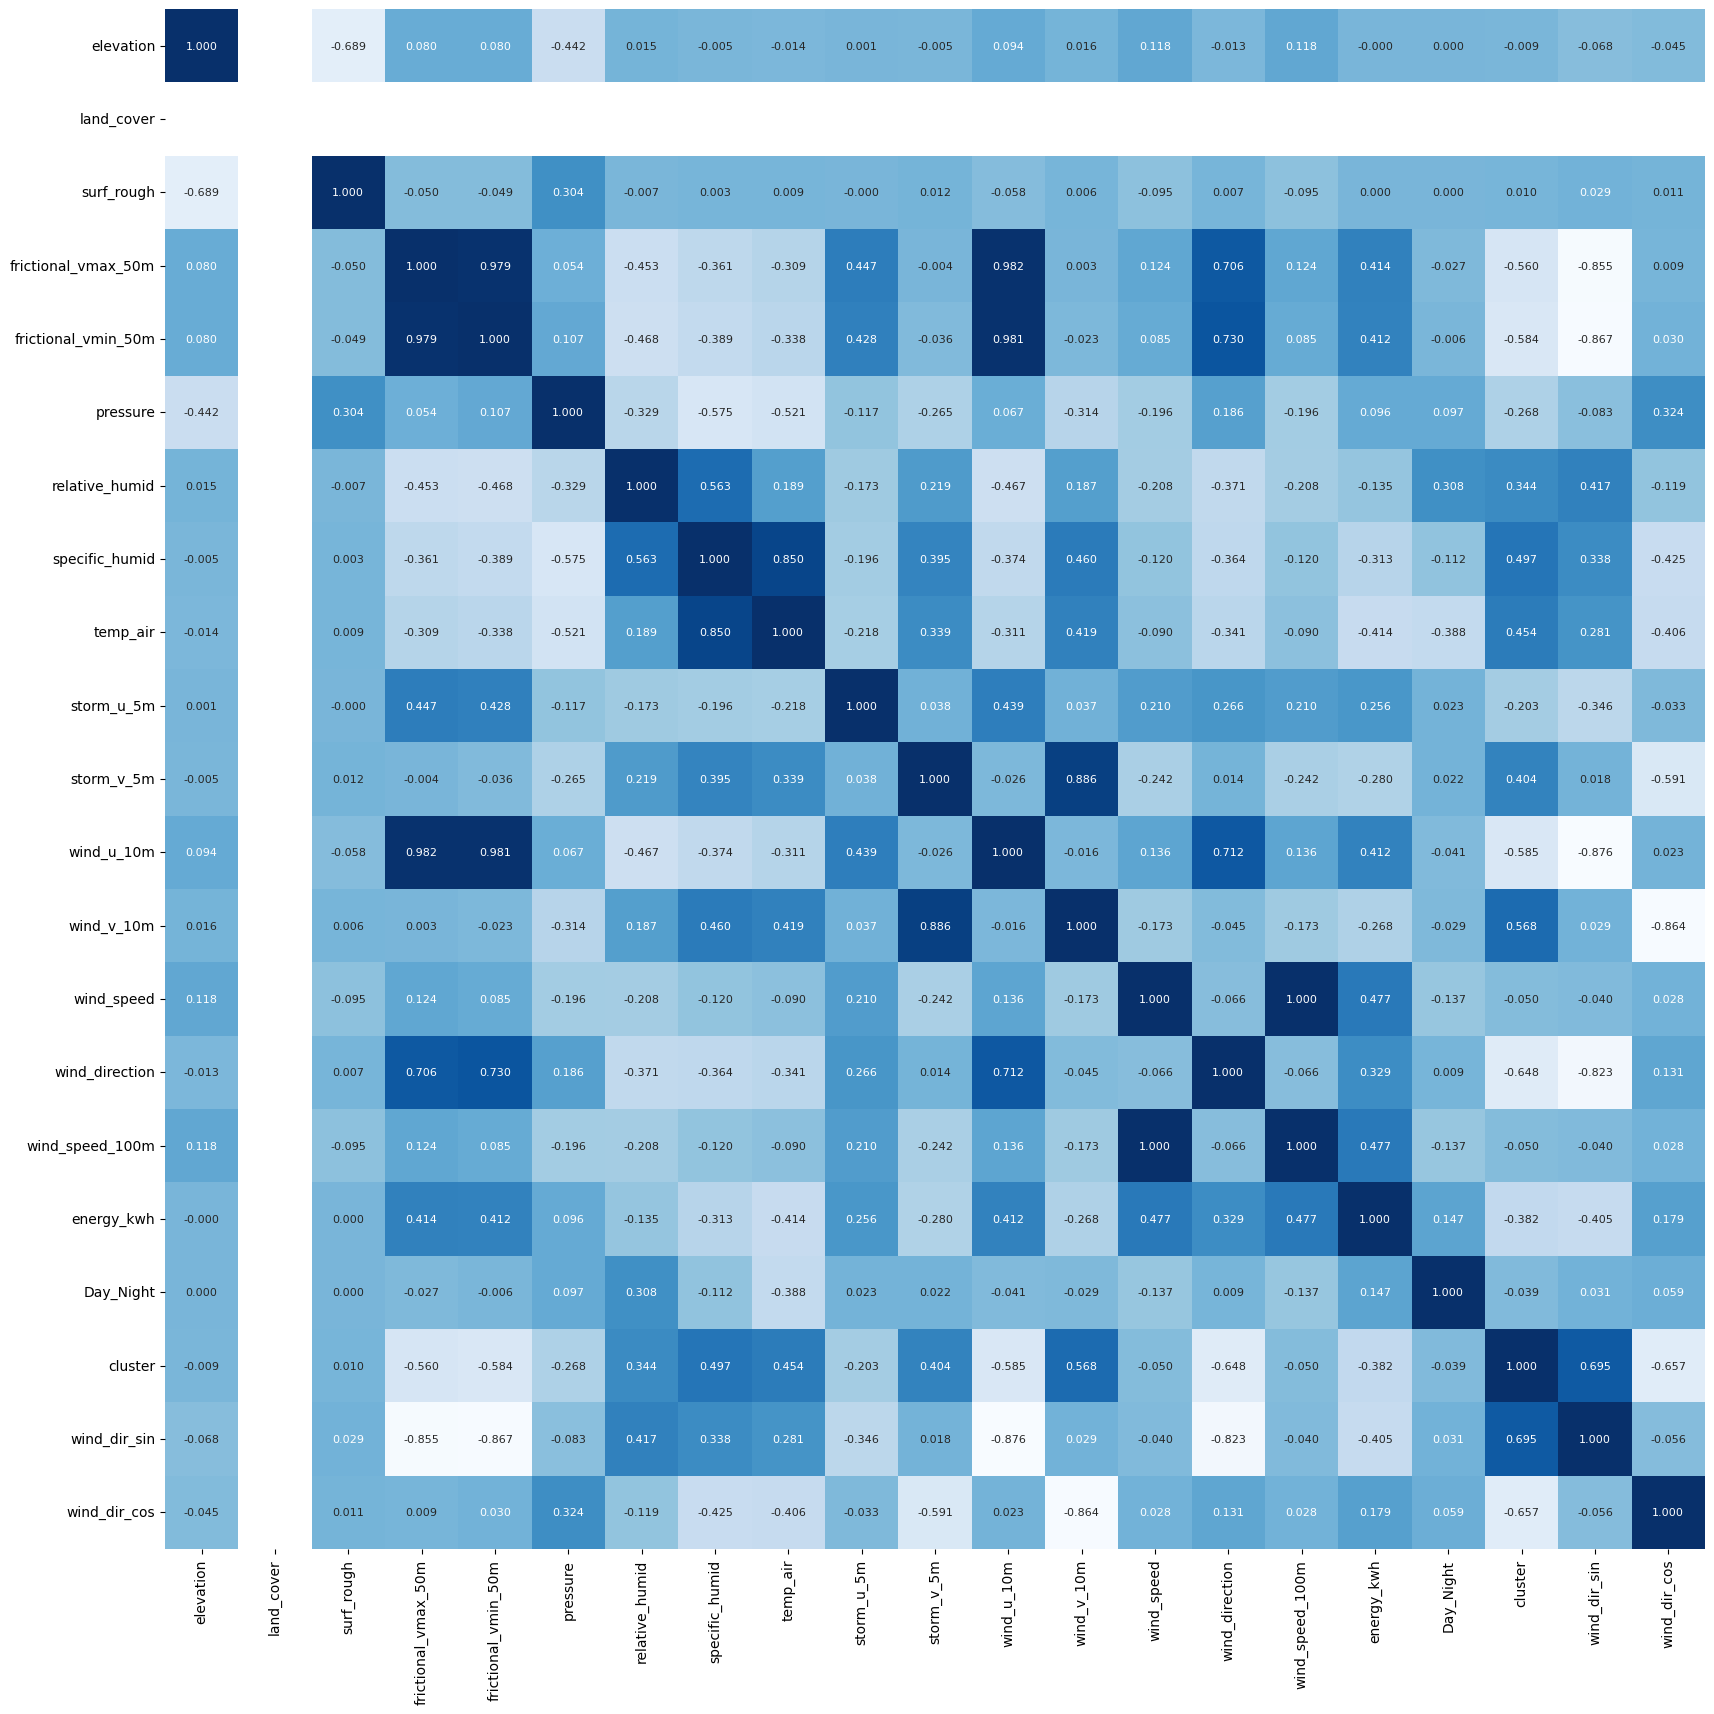

In [18]:
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(wtg1_df.corr(numeric_only=True),
            annot=True,
            cmap='Blues',
            cbar=False,
            square=True,
            fmt='.3f',
            annot_kws={'size': 8})

plt.show()

In [19]:
import scipy.stats as spst

# target : energy_kwh
target = 'energy_kwh'

corrs = []

for i in wtg1_df.columns:
    if i==target or not pd.api.types.is_numeric_dtype(wtg1_df[i]):
        continue
    corr,p_val = spst.pearsonr(wtg1_df[target], wtg1_df[i])
    if p_val < 0.05 and corr>0.1:
        corrs.append((corr,p_val, i))
        
corrs.sort(reverse=True)

C:\Users\User\AppData\Local\Temp\ipykernel_13212\2260817905.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,p_val = spst.pearsonr(wtg1_df[target], wtg1_df[i])


In [20]:
for i in corrs:
    print(f"{i[2]} : \n corr : {i[0]}, p_val : {i[1]}")


wind_speed_100m : 
 corr : 0.47658046863677933, p_val : 0.0
wind_speed : 
 corr : 0.47658046848708985, p_val : 0.0
frictional_vmax_50m : 
 corr : 0.4137322764124334, p_val : 0.0
wind_u_10m : 
 corr : 0.41210338106816957, p_val : 0.0
frictional_vmin_50m : 
 corr : 0.4119651460325796, p_val : 0.0
wind_direction : 
 corr : 0.3285373224447447, p_val : 0.0
storm_u_5m : 
 corr : 0.25642210329695986, p_val : 0.0
wind_dir_cos : 
 corr : 0.17911400925973678, p_val : 0.0
Day_Night : 
 corr : 0.14665859476927456, p_val : 0.0


In [21]:
# 이전에 뭔가 잘못한듯?
# cluster는 매우 높은 상관관계를 가짐.

# 이번에는 또 낮게 나옴..

In [22]:
target = 'energy_kwh'

numeric_columns = wtg1_df.select_dtypes(include=['float', 'int']).columns
numeric_columns = numeric_columns.drop(target)

scaler = StandardScaler()
wtg1_df[numeric_columns] = scaler.fit_transform(wtg1_df[numeric_columns])

# 시간 종속성이 약하다는 말을 한번 믿어봅시다.
x = wtg1_df[numeric_columns]
y = wtg1_df[target]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# ===============
# 아래는 테스트 파일 따로 로드했을 때 저렇게 로드할거임.
# ===============

# # Feature와 Target 분리
# x_train = wtg1_df[numeric_columns]
# y_train = wtg1_df[target]

# # 10은 경주풍력단지 개수
# # 산술 평균치를 예측하도록 하면 영광에 똑같이 적용했을때 35만 곱해주면 되지 않나.
# y_train /= 10

In [23]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.model_selection import RandomizedSearchCV

log_file = open(os.path.join(ipynb_path, "testBaseline_clustering/model_training_log.txt"), "w")

model_name = []
r2score = []
rmse = []
nmae = []

models = [
    GradientBoostingRegressor(),
    SVR(),
    RandomForestRegressor(),
    LinearRegression(),
    ExtraTreesRegressor(),
    AdaBoostRegressor(),
    DecisionTreeRegressor(),
    XGBRegressor(),
    XGBRFRegressor(),
]

# importance 혹은 coef_를 그려주는 함수
def plot_feature_importance(model, X_train, model_name):
    try:
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importance : {model_name}")
        plt.bar(range(X_train.shape[1]), importances[indices], align='center')
        plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(ipynb_path, f"testBaseline_clustering/{model_name}_feature_importance.png"))
        plt.close()
    except AttributeError:
        if hasattr(model, 'coef_'):
            importances = np.abs(model.coef_)
            indices = np.argsort(importances)[::-1]

            plt.figure(figsize=(10, 6))
            plt.title(f"Coefficient : {model_name}")
            plt.bar(range(X_train.shape[1]), importances[indices], align='center')
            plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
            plt.tight_layout()
            plt.savefig(os.path.join(ipynb_path, f"testBaseline_clustering/{model_name}_coefficient.png"))
            plt.close()
        else:
            print(f"{model_name} has no feature importances or coefficients.")


for model in models:
    model_name_current = model.__class__.__name__
    log_file.write(f"Training {model_name_current}\n")
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    model_name.append(model_name_current)
    r2score.append(r2_score(y_test, y_pred) * 100)
    rmse.append(mean_squared_error(y_test, y_pred, squared=False))
    
    mae = mean_absolute_error(y_test, y_pred)
    nmae.append(mae / y_test.mean())
    
    log_file.write(f"R2 Score: {r2_score(y_test, y_pred) * 100:.2f}\n")
    log_file.write(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}\n")
    log_file.write(f"NMAE: {nmae[-1]:.4f}\n\n")
    
    plot_feature_importance(model, X_train, model_name_current)

models_df = pd.DataFrame({
    "Model-Name": model_name,
    "R2_score": r2score,
    'RMSE': rmse,
    'NMAE': nmae
})

models_df = models_df.astype({"R2_score": float, "RMSE": float, "NMAE": float})
models_df = models_df.sort_values("NMAE", ascending=False)

log_file.close()


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the func

SVR has no feature importances or coefficients.


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the func

In [24]:
print(models_df)

                  Model-Name   R2_score         RMSE      NMAE
1                        SVR  34.906276  4932.750932  0.588601
5          AdaBoostRegressor  48.343292  4394.232095  0.547873
3           LinearRegression  51.050297  4277.545730  0.476689
8             XGBRFRegressor  65.138209  3609.894199  0.401638
0  GradientBoostingRegressor  68.045203  3456.110805  0.376743
7               XGBRegressor  87.866917  2129.635210  0.216872
6      DecisionTreeRegressor  90.369200  1897.364710  0.079416
2      RandomForestRegressor  95.584706  1284.693227  0.078773
4        ExtraTreesRegressor  95.968790  1227.544838  0.062428
